# Part1

## Dependencies

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = '#ffffff'

### Access CIFAR10 dataset

In [2]:
data_dir = 'D:/GISenseLab/DataSet/Imagenet.tgz/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Visualize some images

Label: airplane


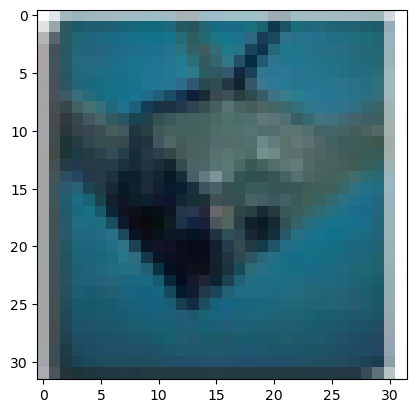

In [3]:
train_ds = ImageFolder(data_dir+'/train')
valid_ds = ImageFolder(data_dir+'/test')

image, label = train_ds[985] # select one image
plt.imshow(image)
print('Label:', train_ds.classes[label])

## Convert image into Tensors

In [4]:
# Use torchvision.transforms
train_tfms = tt.Compose([tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor()])

In [5]:
# again use the ImageLoader function to form training and testing sets of images.
# PyTorch datasets
train_ds = ImageFolder(data_dir + '/train',train_tfms)
valid_ds = ImageFolder(data_dir + '/test',valid_tfms)

# Gather  data in data loaders

1. batch size as 104: optimize & experiment with different values.
2. shuffle set true: images can reshuffled at every epoch.
3. batch size: specifies the number os samples that are loaded per batch.
4. num_workers: the number of sub processors used while loading the data.
5. pin_memory set true: when you want you dataset to be pushed on GPU.

In [6]:
batch_size = 104

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

# Using dataloader of training dataset to visualize a batch of images

images.shape: torch.Size([104, 3, 32, 32])


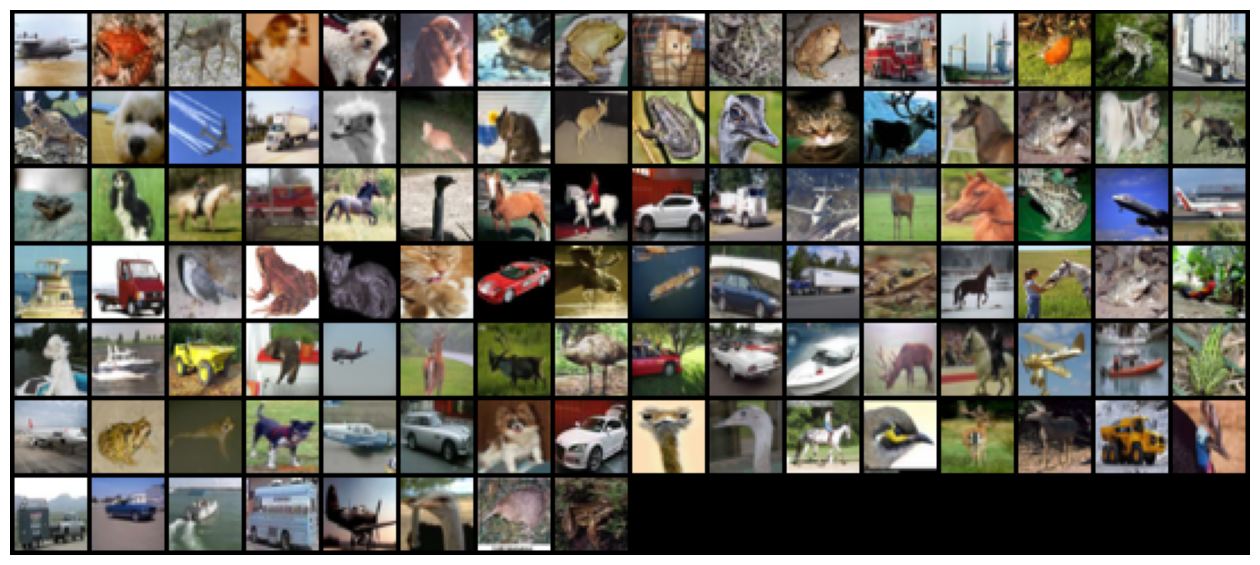

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

All the images in the dataloader and the number of rows are given as the input to plot.
The pytorch image format has channel at its first place, so we need to permute function to place it at the last place as that is the matplotlib expects.

# Data Normalization

In neural networks in the training process, the input data gets multiplied by the weights in each layer and then a bias is added to it.
Images consists of RGB channels. We need them all to be inside a range so that the gradient don't get affected due to the channels.

In [8]:
train_loader = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True, num_workers=4, pin_memory=True)
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()
mean, std

(tensor(0.4734), tensor(0.2516))

In [9]:
train_normalised = tt.Compose([tt.ToTensor(),tt.Normalize(mean,std)])
train_nz = ImageFolder(data_dir + '/train',train_normalised)

loader_normalised=DataLoader(train_nz, batch_size=len(train_nz),num_workers=2)
data1=next(iter(loader_normalised))

mean_normalised=data1[0].mean()
std_normalised=data1[0].std()
mean_normalised,std_normalised

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),

                         tt.ToTensor(),
                         tt.Normalize(mean,std)])
train_ds = ImageFolder(data_dir+'/train', train_tfms)

batch_size=104
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([104, 3, 32, 32])


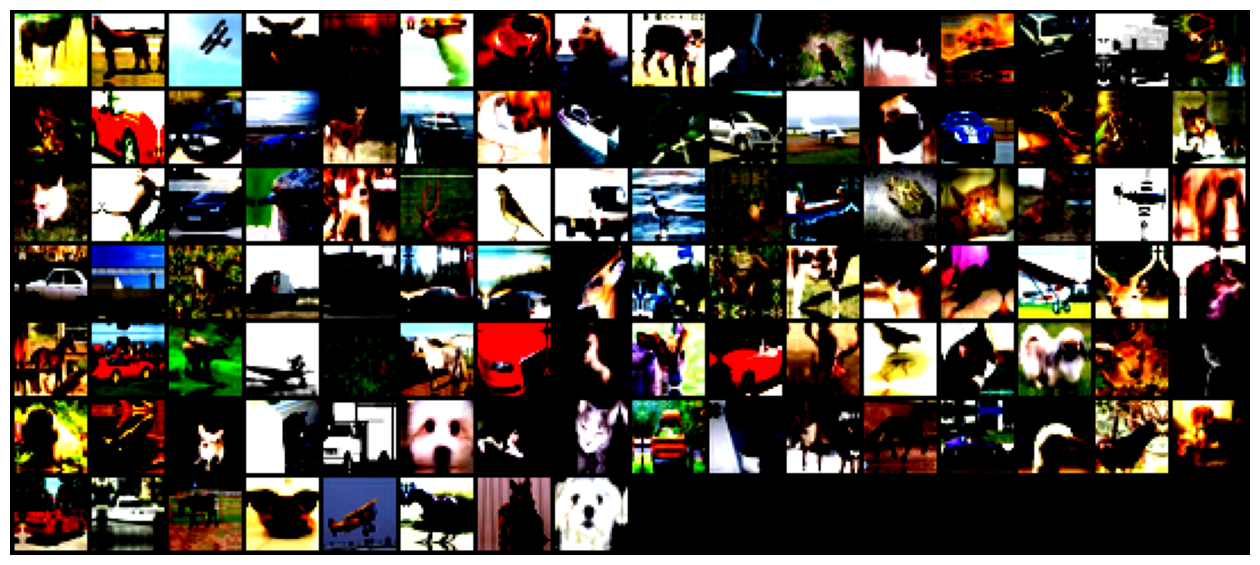

In [10]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cpu')

In [14]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x